Sources:
https://www.asep.org/asep/asep/JEPonlineJUNE_2022_Malkinson.pdf

https://www.nature.com/articles/s41598-023-43024-x.pdf

https://www.sumarpo.com/blogs/triathlon/data-driven-triathlon-training-mastering-metrics-ai-coaching-and-wearables-without-overwhelm

https://www.kaggle.com/datasets/aiaiaidavid/ironman-703-race-data-between-2004-and-2020?resource=download (data set)

In [1]:
#All imports possibly needed

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
from plotly.offline import iplot

In [2]:
class Run:
    def __init__(self, distance_km, duration_min):
        """Creating a run class that sets the distance of the run and duration of the run in km and minutes"""
        self.distance = distance_km
        self.duration = duration_min
        self.pace = duration_min / distance_km  #min/km


In [3]:
class Runner:
    """Creating a runner class that takes in a person and their pace when running. The function 
        predict_time returns the predicted time of an input distance given the time of a run a runner has already completed"""
    def __init__(self, name):
        self.name = name
        self.runs = []

    def add_run(self, run):
        self.runs.append(run)

    def average_pace(self):
        if not self.runs:
            return None
        return sum(run.pace for run in self.runs) / len(self.runs)

    def predict_time(self, race_distance_km):
        pace = self.average_pace()
        if pace is None:
            return None
        return pace * race_distance_km


In [4]:
class Bike:
    def __init__(self, distance_km, duration_min):
        """Creating a bike class that sets the distance of the bike and duration of the bike in km and minutes"""
        self.distance_bike = distance_km
        self.duration_bike = duration_min
        self.pace_bike = duration_min / distance_km  #min/km

class Biker:
    """Creating a biker class that takes in a person and their pace when biking. The function 
        predict_time returns the predicted time of an input distance given the time of a bike a biker has already completed"""
    def __init__(self, name):
        self.name = name
        self.bikes = []

    def add_bike(self, bike):
        self.bikes.append(bike)

    def average_pace(self):
        if not self.bikes:
            return None
        return sum(bike.pace_bike for bike in self.bikes) / len(self.bikes)

    def predict_time(self, race_distance_km):
        pace = self.average_pace()
        if pace is None:
            return None
        return pace * race_distance_km

In [5]:
class Swim:
     def __init__(self, distance_km, duration_min):
        """Creating a bike class that sets the distance of the bike and duration of the bike in km and minutes"""
        self.distance_swim = distance_km
        self.duration_swim = duration_min
        self.pace_swim = duration_min / distance_km  #min/km

class Swimmer:
    """Creating a swimmer class that takes in a person and their pace when swimming. The function 
        predict_time returns the predicted time of an input distance given the time of a swim a swimmer has already completed"""
    def __init__(self, name):
        self.name = name
        self.swims = []

    def add_swim(self, swim):
        self.swims.append(swim)

    def average_pace(self):
        if not self.swims:
            return None
        return sum(swim.pace_swim for swim in self.swims) / len(self.swims)

    def predict_time(self, race_distance_km):
        pace = self.average_pace()
        if pace is None:
            return None
        return pace * race_distance_km

In [6]:
class Triathlete:
    """Creating a triathlete class that takes in fitness metrics such as VO2 max, resting heart rate, training hours and fatigue. 
        It uses metrics I combined from Strava and Garmin (source: Copilot, accessed 11/12/25 with prompt "How to add vo2 max, resting heart rate, 
        training hours, and fatigue metrics into a class using equations from fitness apps such as Garmin and Strava). The metrics act as a 
        modifier for total finish time by scaling the times based on inputted values."""
    def __init__(self, name):
        self.name = name
        self.runner = Runner(name)
        self.biker = Biker(name)
        self.swimmer = Swimmer(name)
        self.vo2_max = None
        self.resting_hr = None
        self.training_hours = {"swim": 0, "bike": 0, "run": 0}

    def set_fitness_metrics(self, vo2_max, resting_hr):
        self.vo2_max = vo2_max
        self.resting_hr = resting_hr

    def _fitness_modifier(self):
        if self.vo2_max is None or self.resting_hr is None:
            return 1.0 
        return 1.0 - (self.vo2_max - 40) * 0.005 + (self.resting_hr - 60) * 0.003

    def set_training_hours(self, swim, bike, run):
        self.training_hours["swim"] = swim
        self.training_hours["bike"] = bike
        self.training_hours["run"] = run


    def adjusted_pace(self, base_pace, hours):
        return base_pace * (1 - 0.01 * min(hours, 10))  #up to 10% improvement

    def fatigue_penalty(self, distance_km):
        return 1 + 0.02 * (distance_km - 5)  #2% slower per km beyond 5K


    def predict_triathlon_time(self, swim_km, bike_km, run_km):
        swim_pace = self.swimmer.average_pace()
        bike_pace = self.biker.average_pace()
        run_pace = self.runner.average_pace()

        if None in (swim_pace, bike_pace, run_pace):
            return None

        swim_time = self.adjusted_pace(swim_pace, self.training_hours["swim"]) * self.fatigue_penalty(swim_km) * swim_km
        bike_time = self.adjusted_pace(bike_pace, self.training_hours["bike"]) * self.fatigue_penalty(bike_km) * bike_km
        run_time = self.adjusted_pace(run_pace, self.training_hours["run"]) * self.fatigue_penalty(run_km) * run_km

        modifier = self._fitness_modifier()
        total_time = (swim_time + bike_time + run_time) * modifier
        return total_time


***

In [7]:
#Testing to see if class and functions work
jil = Triathlete("Jil")
jil.runner.add_run(Run(5, 21))
jil.biker.add_bike(Bike(40, 80))
jil.swimmer.add_swim(Swim(1, 21))

jil.set_fitness_metrics(vo2_max=56, resting_hr=50)
jil.set_training_hours(swim=8, bike=12, run=10)

predicted_time = jil.predict_triathlon_time(swim_km=1.5, bike_km=40, run_km=10)
print(f"Predicted Olympic Triathlon Time: {predicted_time:.1f} minutes")


Predicted Olympic Triathlon Time: 169.9 minutes


**The above value is relatively accurate as to how I've been performing in triathlons recently. My triathlon time for an Olympic distance is 173 minutes, which is only 4 minutes off the above time. The model, of course, is not perfect, as it fails to account for training intensity and type of training (such as sprints, zone 2 training, and threshold training). While the model accounts for fatigue during the race, it does not include factors such as pre-race nutrition, sleep, and recovery (as in tapering before an important race).**


---

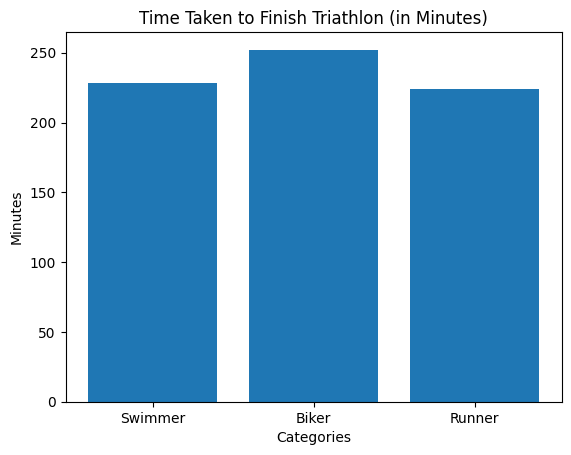

In [8]:
#Creating a graph to predict total finish time based on a triathlete's strongest leg while keeping other paces constant

swimmer_background = Triathlete("Swimmer")
swimmer_background.swimmer.add_swim(Swim(1.5, 15))
swimmer_background.biker.add_bike(Bike(40, 90))
swimmer_background.runner.add_run(Run(10, 56))

biker_background = Triathlete("Biker")
biker_background.swimmer.add_swim(Swim(1.5, 29))
biker_background.biker.add_bike(Bike(40, 60))
biker_background.runner.add_run(Run(5, 56))

runner_background = Triathlete("Runner")
runner_background.swimmer.add_swim(Swim(1.5, 29))
runner_background.biker.add_bike(Bike(40, 90))
runner_background.runner.add_run(Run(10, 40))

categories = ['Swimmer', 'Biker', 'Runner']
values = [swimmer_background.predict_triathlon_time(swim_km=1.5, bike_km=40, run_km=10),
          biker_background.predict_triathlon_time(swim_km=1.5, bike_km=40, run_km=10),
          runner_background.predict_triathlon_time(swim_km=1.5, bike_km=40, run_km=10)]

plt.bar(categories, values)

# Add labels and a title
plt.xlabel('Categories')
plt.ylabel('Minutes')
plt.title('Time Taken to Finish Triathlon (in Minutes)')

# Display the chart
plt.show()

**The above code creates an elite swimmer, an elite biker, and an elite runner. Paces for the weaker legs of the elite athletes are kept constant and can be found in an article from "Mottiv" written by Taren Gesell (https://www.mymottiv.com/blog/average-triathlon-finish-times). The bar chart highlights how an elite biker will outpace an elite swimmer and an elite runner during an Olympic Triathlon.**

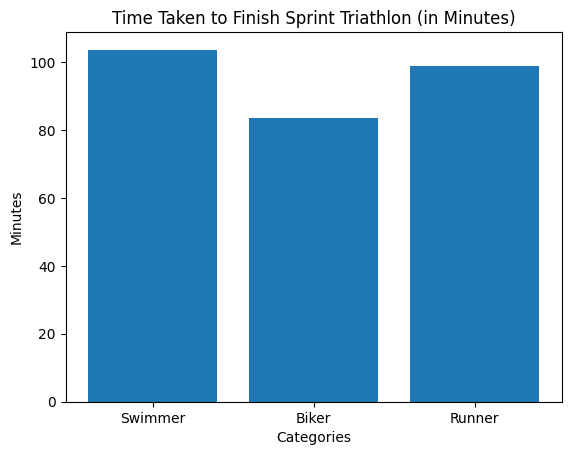

In [9]:

swimmer_background_sprint = Triathlete("Swimmer")
swimmer_background_sprint.swimmer.add_swim(Swim(0.75, 8))
swimmer_background_sprint.biker.add_bike(Bike(20, 51))
swimmer_background_sprint.runner.add_run(Run(5, 30))

biker_background_sprint = Triathlete("Biker")
biker_background_sprint.swimmer.add_swim(Swim(0.75, 16))
biker_background_sprint.biker.add_bike(Bike(20, 30))
biker_background_sprint.runner.add_run(Run(5, 30))

runner_background_sprint = Triathlete("Runner")
runner_background_sprint.swimmer.add_swim(Swim(0.75, 16))
runner_background_sprint.biker.add_bike(Bike(20, 51))
runner_background_sprint.runner.add_run(Run(5, 18))

categories = ['Swimmer', 'Biker', 'Runner']
values = [swimmer_background_sprint.predict_triathlon_time(swim_km=0.75, bike_km=20, run_km=5),
          biker_background_sprint.predict_triathlon_time(swim_km=0.75, bike_km=20, run_km=5),
          runner_background_sprint.predict_triathlon_time(swim_km=0.75, bike_km=20, run_km=5)]

plt.bar(categories, values)


plt.xlabel('Categories')
plt.ylabel('Minutes')
plt.title('Time Taken to Finish Sprint Triathlon (in Minutes)')


plt.show()

**Using the same method for the sprint triathlon data, we see that an elite swimmer actually outperforms an elite biker and an elite runner during a sprint triathlon, which consists of 750 meteres swimming, 20 km biking, and 5km running. The data used to create these metrics does not account for age or gender. Instead, the data used comes from females ages 18-24. This limits the extent to which we can apply this analysis; however, later in this notebook, I applied gender metrics to account for these limitations. Since this model is geared toward collegiate triathletes, age groups outside of 18-24 were not used.**

---

In [10]:
athletes = [swimmer_background, biker_background, runner_background]
labels = ["Swimmer", "Biker", "Runner"]
swim_km, bike_km, run_km = 1.5, 40, 10

data = {
    "Athlete": [],
    "Discipline": [],
    "Time": []
}

for athlete, label in zip(athletes, labels):
    data["Athlete"] += [label] * 3
    data["Discipline"] += ["Swim", "Bike", "Run"]
    data["Time"] += [
        athlete.swimmer.predict_time(swim_km),
        athlete.biker.predict_time(bike_km),
        athlete.runner.predict_time(run_km)
    ]


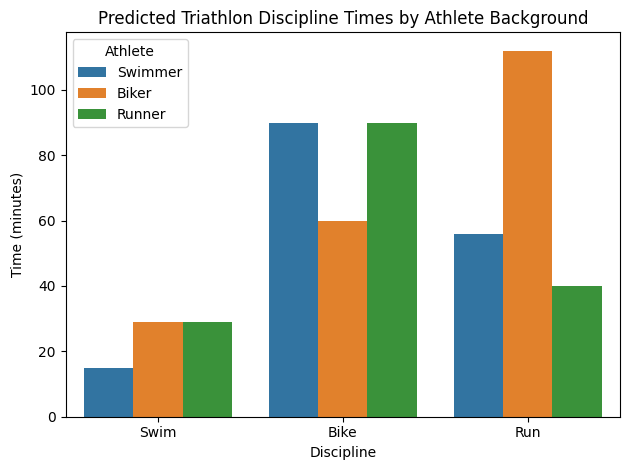

In [11]:
df = pd.DataFrame(data)

sns.barplot(data=df, x="Discipline", y="Time", hue="Athlete")
plt.title("Predicted Triathlon Discipline Times by Athlete Background")
plt.ylabel("Time (minutes)")
plt.xlabel("Discipline")
plt.legend(title="Athlete")
plt.tight_layout()
plt.show()


---

In [13]:
import random

athletes = []
labels = []
data = {
    "Athlete": [],
    "Swim_Time": [],
    "Bike_Time": [],
    "Run_Time": [],
    "Total_Time": [],
    "VO2_max": [],
    "Resting_HR": [],
    "Swim_Training": [],
    "Bike_Training": [],
    "Run_Training": []
}

for i in range(30):  # Create 30 athletes
    label = f"Athlete_{i+1}"
    tri = Triathlete(label)

    # Random training data
    swim_train = random.randint(2, 10)
    bike_train = random.randint(2, 10)
    run_train = random.randint(2, 10)

    # Random fitness metrics
    vo2 = random.randint(45, 65)
    hr = random.randint(45, 65)

    # Add workouts
    tri.swimmer.add_swim(Swim(1, random.randint(15, 25)))
    tri.biker.add_bike(Bike(20, random.randint(25, 45)))
    tri.runner.add_run(Run(5, random.randint(18, 30)))

    tri.set_fitness_metrics(vo2_max=vo2, resting_hr=hr)
    tri.set_training_hours(swim=swim_train, bike=bike_train, run=run_train)

    # Predict times
    swim_time = tri.swimmer.predict_time(1.5)
    bike_time = tri.biker.predict_time(40)
    run_time = tri.runner.predict_time(10)
    total_time = tri.predict_triathlon_time(1.5, 40, 10)

    # Store data
    athletes.append(tri)
    labels.append(label)
    data["Athlete"].append(label)
    data["Swim_Time"].append(swim_time)
    data["Bike_Time"].append(bike_time)
    data["Run_Time"].append(run_time)
    data["Total_Time"].append(total_time)
    data["VO2_max"].append(vo2)
    data["Resting_HR"].append(hr)
    data["Swim_Training"].append(swim_train)
    data["Bike_Training"].append(bike_train)
    data["Run_Training"].append(run_train)


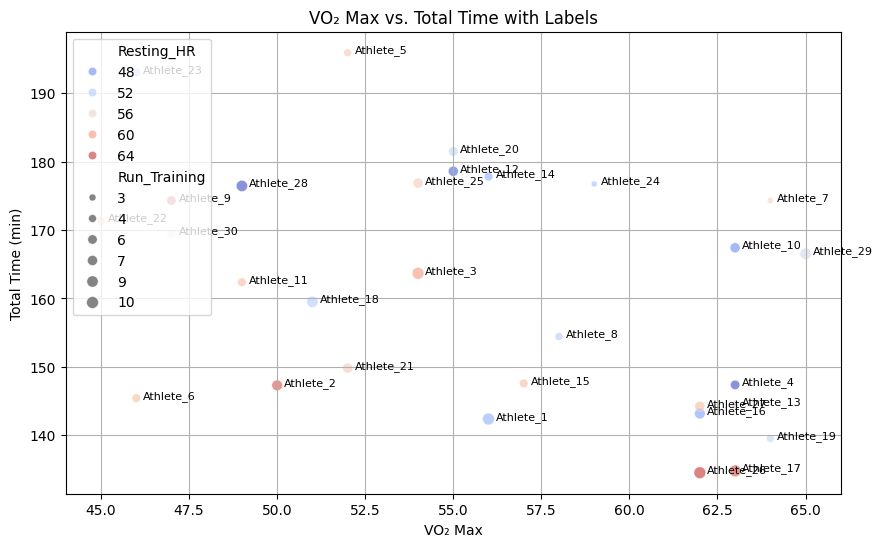

In [14]:
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="VO2_max", y="Total_Time", hue="Resting_HR", size="Run_Training", palette="coolwarm", alpha=0.6)
for i in range(len(df)):
    plt.text(df["VO2_max"][i]+0.2, df["Total_Time"][i], df["Athlete"][i], fontsize=8)
plt.title("VO₂ Max vs. Total Time with Labels")
plt.xlabel("VO₂ Max")
plt.ylabel("Total Time (min)")
plt.grid(True)
plt.legend(loc="upper left")

plt.show()
